In [1]:
import torch
import matplotlib.pyplot as plt
from models.conjugate_spatial_lm import ConjugateSpatialLM
from methods.iscd import ISCD
import seaborn as sns
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

from utils.plotting import plot_beta_posteriors, plot_location_changes, plot_location_changes_response

# Posterior inference under clean data

In [2]:
# 1) Read the preprocessed Meuse data
df = pd.read_csv("data/meuse_raw.csv")

print("Data head:\n", df.head())

Data head:
         x       y  cadmium  copper  lead  zinc   elev      dist    om  ffreq  \
0  181072  333611     11.7      85   299  1022  7.909  0.001358  13.6      1   
1  181025  333558      8.6      81   277  1141  6.983  0.012224  14.0      1   
2  181165  333537      6.5      68   199   640  7.800  0.103029  13.0      1   
3  181298  333484      2.6      81   116   257  7.655  0.190094   8.0      1   
4  181307  333330      2.8      48   117   269  7.480  0.277090   8.7      1   

   soil  lime landuse  dist.m  
0     1     1      Ah      50  
1     1     1      Ah      30  
2     1     1      Ah     150  
3     2     0      Ga     270  
4     2     0      Ah     380  


In [3]:


# ---------------------------------------------------------------
# 2.  Create response and transformed covariates
# ---------------------------------------------------------------
df["log_zinc"] = np.log(df["zinc"])      # response
df["dist_sq"]  = np.sqrt(df["dist"])     # √‑distance (per your recipe)

# Recode ffreq
df["ffreq"] = df["ffreq"].apply(lambda x: 0 if x in [2, 3] else 1)

# Factor variables → one‑hot
ffreq_dummies = pd.get_dummies(df["ffreq"].astype("category"), prefix="ffreq", drop_first=True)
# soil_dummies  = pd.get_dummies(df["soil"].astype("category"),  prefix="soil",  drop_first=True)

# Continuous covariates to standardise
cont_cols = ["dist_sq", "elev", "om"]
df[cont_cols] = (df[cont_cols] - df[cont_cols].mean()) / df[cont_cols].std(ddof=0)

# Combine design matrix (no intercept)
X_df = pd.concat([df[cont_cols], ffreq_dummies], axis=1)
# X_df = df[cont_cols]
covariate_cols = X_df.columns.tolist()      # keep the order

# ---------------------------------------------------------------
# 3.  Standardise the response as well  (optional but common)
# ---------------------------------------------------------------
df["log_zinc"] = (df["log_zinc"] - df["log_zinc"].mean()) / df["log_zinc"].std(ddof=0)
response_col = "log_zinc"

# ---------------------------------------------------------------
# 4.  Shift / scale coordinates  (so distances are ~ O(1))
# ---------------------------------------------------------------
x_min, y_min = df["x"].min(), df["y"].min()
df["x_km"] = (df["x"] - x_min) / 1000.0     # metres → kilometres
df["y_km"] = (df["y"] - y_min) / 1000.0
location_cols = ["x_km", "y_km"]

# ---------------------------------------------------------------
# 5.  Convert to PyTorch tensors
# ---------------------------------------------------------------
locations = torch.tensor(df[location_cols].values, dtype=torch.float32)       # (n, 2)
y         = torch.tensor(df[response_col].values,    dtype=torch.float32)     # (n,)
X_raw_np = X_df.to_numpy(dtype=np.float32, copy=False)   # (n, p) float32 array
X_raw    = torch.from_numpy(X_raw_np)                    # convert to tensor


# ---------------------------------------------------------------
# 6.  Ready dictionary for ConjugateSpatialLM
# ---------------------------------------------------------------
data_dict = {
    "locations": locations,   # (n, 2)
    "X": X_raw,               # (n, p_cov)  without intercept
    "y": y                    # (n,)
}

In [4]:
covariate_cols

['dist_sq', 'elev', 'om', 'ffreq_1']

In [5]:
# Define true parameters
phi = 0.16 # Spatial decay parameter
delta2 = 0.2  # Noise-to-spatial variance ratio

# Define prior parameters
V_beta = torch.eye(1) * 1.0  # Prior covariance for beta
mu_beta = torch.zeros(1)  # Prior mean for beta
a_sigma = 2.0  # Shape parameter of IG prior for sigma^2
b_sigma = 1.0  # Scale parameter of IG prior for sigma^2

In [6]:
# Instantiate the model
model = ConjugateSpatialLM(V_beta=V_beta, mu_beta=mu_beta, a_sigma=a_sigma, b_sigma=b_sigma, phi=phi, delta2=delta2)

/Users/roinaveiro/Library/CloudStorage/OneDrive-CUNEF/CUNEF/research/posterior_attraction/models/conjugate_spatial_lm.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.V_beta = torch.tensor(V_beta, dtype=torch.float32)
/Users/roinaveiro/Library/CloudStorage/OneDrive-CUNEF/CUNEF/research/posterior_attraction/models/conjugate_spatial_lm.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mu_beta = torch.tensor(mu_beta, dtype=torch.float32)


In [7]:
# synthetic_data = generate_synthetic_data()
# Compute posterior

posterior_beta_given_sigma2, posterior_sigma2 = model.compute_posterior(data_dict)

/Users/roinaveiro/Library/CloudStorage/OneDrive-CUNEF/CUNEF/research/posterior_attraction/models/conjugate_spatial_lm.py:72: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3687.)
  + self.mu_beta.T @ V_beta_inv @ self.mu_beta


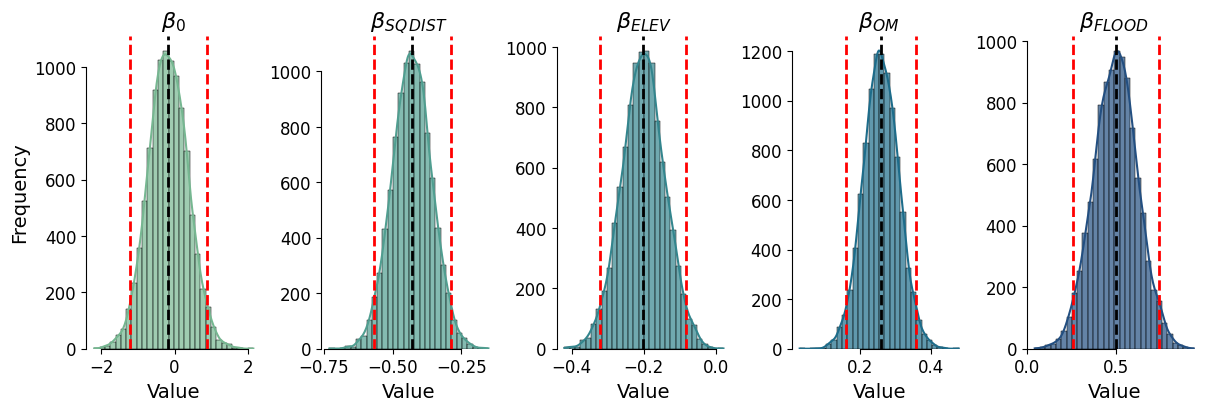

(<Figure size 1200x400 with 5 Axes>,
 array([<Axes: title={'center': '$\\beta_{0}$'}, xlabel='Value', ylabel='Frequency'>,
        <Axes: title={'center': '$\\beta_{SQ\\,DIST}$'}, xlabel='Value'>,
        <Axes: title={'center': '$\\beta_{ELEV}$'}, xlabel='Value'>,
        <Axes: title={'center': '$\\beta_{OM}$'}, xlabel='Value'>,
        <Axes: title={'center': '$\\beta_{FLOOD}$'}, xlabel='Value'>],
       dtype=object))

In [8]:
plot_beta_posteriors(
    posterior_beta_given_sigma2,
    posterior_sigma2,
    num_samples=10000,
    bins=30,
    figsize=(12, 4), 
    save_path="figures/clean_posteriors.png",
)

# Adversarial attack

/Users/roinaveiro/Library/CloudStorage/OneDrive-CUNEF/CUNEF/research/posterior_attraction/models/conjugate_spatial_lm.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta_mean = torch.tensor(params.get("beta_mean", self.mu_beta), dtype=torch.float32)
/Users/roinaveiro/Library/CloudStorage/OneDrive-CUNEF/CUNEF/research/posterior_attraction/models/conjugate_spatial_lm.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta_cov = torch.tensor(params.get("beta_cov", self.V_beta), dtype=torch.float32)


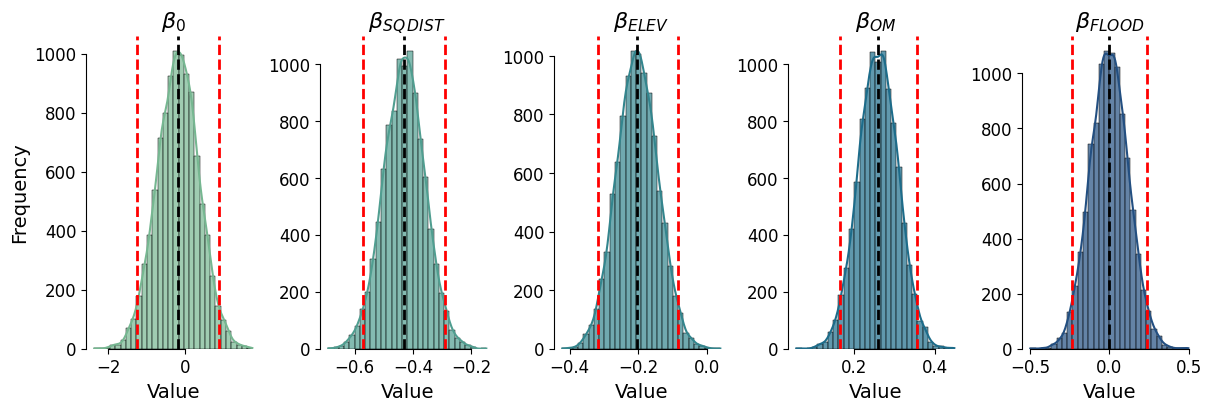

(<Figure size 1200x400 with 5 Axes>,
 array([<Axes: title={'center': '$\\beta_{0}$'}, xlabel='Value', ylabel='Frequency'>,
        <Axes: title={'center': '$\\beta_{SQ\\,DIST}$'}, xlabel='Value'>,
        <Axes: title={'center': '$\\beta_{ELEV}$'}, xlabel='Value'>,
        <Axes: title={'center': '$\\beta_{OM}$'}, xlabel='Value'>,
        <Axes: title={'center': '$\\beta_{FLOOD}$'}, xlabel='Value'>],
       dtype=object))

In [9]:
adversarial_mean = posterior_beta_given_sigma2(posterior_sigma2.mean).mean
adversarial_mean[4] = 0.0
adversarial_posterior_params = {
    "beta_mean": adversarial_mean,
    "beta_cov": posterior_beta_given_sigma2(torch.tensor(1.0)).covariance_matrix,
    "sigma2_shape": posterior_sigma2.concentration,
    "sigma2_scale": posterior_sigma2.rate
}

adversarial_beta_given_sigma2, adversarial_sigma2 = model.define_adversarial_posterior(adversarial_posterior_params)
adversarial_posterior = (adversarial_beta_given_sigma2, adversarial_sigma2)


plot_beta_posteriors(
    adversarial_beta_given_sigma2,
    adversarial_sigma2,
    num_samples=10000,
    bins=30,
    figsize=(12, 4),
    save_path="figures/adversarial_posterior.png",
)

In [12]:
locations = data_dict["locations"]
locations = locations.requires_grad_(True)

X = data_dict["X"]
X = X.requires_grad_(False)

y = data_dict["y"]
y = y.requires_grad_(False)

n, p = X.shape

reference_data = {
    "locations": locations,
    "X": X,
    "y": y
}

max_row_changes = 2.0
max_total_changes = 40 # 152 locations * 2 changes per location
max_element_change = 1.0


epsilon_real       = 0.001      # step for continuous cols
max_cont_change    = 2.0        # max cumulative |Δ| for continuous

# 1) identify dummy columns
dummy_cols = [j for j, name in enumerate(covariate_cols)
              if name.startswith("ffreq_") or name.startswith("soil_")]

# 2) element‑wise ε map  (same shape as X)
eps_map = torch.full((n, p), epsilon_real)
eps_map[:, dummy_cols] = 1.0          # dummies flip with ε=1

# 3) element‑wise max_change map
max_change = torch.full((n, p), max_cont_change)
max_change[:, dummy_cols] = 1.0       # dummies cannot move beyond one flip


constraints_iscd = {
        "locations": {
            "max_element_change": max_element_change * np.ones(locations.shape),
            "max_row_changes": [max_row_changes] * np.ones(locations.shape[0]),
            "max_changes": max_total_changes
        },
        #"X": {
        #    "max_element_change": max_element_change * np.ones(X.shape),
        #    "max_row_changes": [max_row_changes] * np.ones(X.shape[0]),
        #    "max_changes": max_total_changes,
        #    "epsilon_map":       eps_map
        #}
    }

kl_function = "inclusive"


In [54]:
# Initialize PGD optimizer
fgsm_optimizer = ISCD(
    model=model,
    target_posterior=adversarial_posterior,
    kl_direction=kl_function,
    epsilon=0.001, 
    constraints = constraints_iscd,
    max_oscillations=100,
    dummy_cols=dummy_cols,
    second_order=False,
    verbose=True
)

# Run optimization
optimized_data = fgsm_optimizer.minimize_kl(reference_data_dict=reference_data)
# print("Optimized Data:\n", optimized_data)

Updated locations[(63, 0)] by -0.0010, score=-0.005172, KL=17.157223, total_changes_for_locations=1, osc_count=0
Updated locations[(63, 0)] by -0.0010, score=-0.005177, KL=17.152073, total_changes_for_locations=1, osc_count=0
Updated locations[(63, 0)] by -0.0010, score=-0.005182, KL=17.146887, total_changes_for_locations=1, osc_count=0
Updated locations[(63, 0)] by -0.0010, score=-0.005187, KL=17.141714, total_changes_for_locations=1, osc_count=0
Updated locations[(63, 0)] by -0.0010, score=-0.005191, KL=17.136513, total_changes_for_locations=1, osc_count=0
Updated locations[(63, 0)] by -0.0010, score=-0.005196, KL=17.131344, total_changes_for_locations=1, osc_count=0
Updated locations[(63, 0)] by -0.0010, score=-0.005200, KL=17.126129, total_changes_for_locations=1, osc_count=0
Updated locations[(63, 0)] by -0.0010, score=-0.005205, KL=17.120920, total_changes_for_locations=1, osc_count=0
Updated locations[(63, 0)] by -0.0010, score=-0.005209, KL=17.115692, total_changes_for_location

In [ ]:
# Save the optimized_data dictionary to a file using torch
torch.save(optimized_data, "results/attacked_data_IPA_b1=40_b3=1.0.pt")

## Attack Visualization


In [22]:
ref1 = "IPA_b1=304_b3=0.15"
ref2 = "IPA_b1=40_b3=1.0"
# Load the optimized data from the file
optimized_data1 = torch.load(f"results/attacked_data_{ref1}.pt")
optimized_data2 = torch.load(f"results/attacked_data_{ref2}.pt")

/var/folders/6t/g0m1dgb95tl74_1f_f518pjh0000gn/T/ipykernel_28965/802568782.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  optimized_data1 = torch.load(f"results/attacke

# Induced Posterior

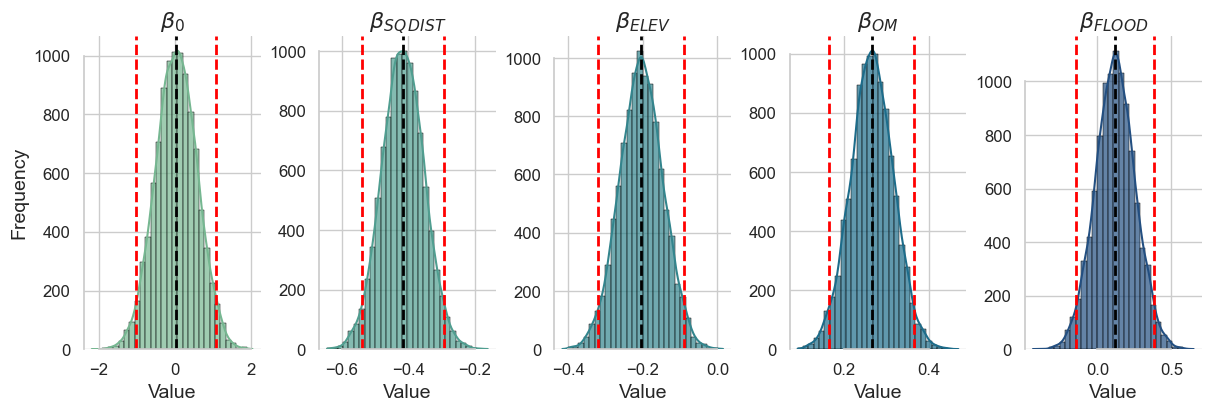

(<Figure size 1200x400 with 5 Axes>,
 array([<Axes: title={'center': '$\\beta_{0}$'}, xlabel='Value', ylabel='Frequency'>,
        <Axes: title={'center': '$\\beta_{SQ\\,DIST}$'}, xlabel='Value'>,
        <Axes: title={'center': '$\\beta_{ELEV}$'}, xlabel='Value'>,
        <Axes: title={'center': '$\\beta_{OM}$'}, xlabel='Value'>,
        <Axes: title={'center': '$\\beta_{FLOOD}$'}, xlabel='Value'>],
       dtype=object))

In [23]:
posterior_beta_given_sigma2, posterior_sigma2 = model.compute_posterior(optimized_data)
plot_beta_posteriors(
    posterior_beta_given_sigma2,
    posterior_sigma2,
    num_samples=10000,
    bins=30,
    figsize=(12, 4),
    save_path=f"figures/tainted_posterior_{ref1}.png",
)

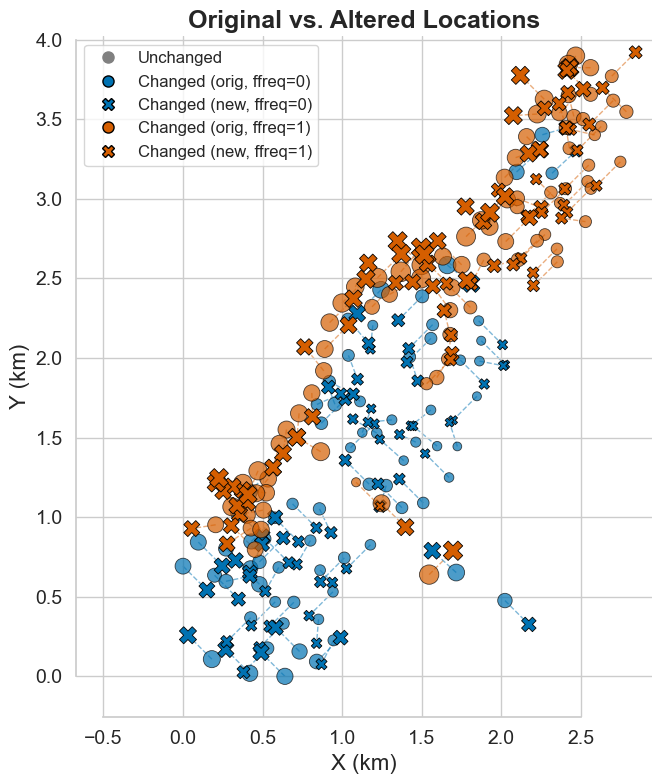

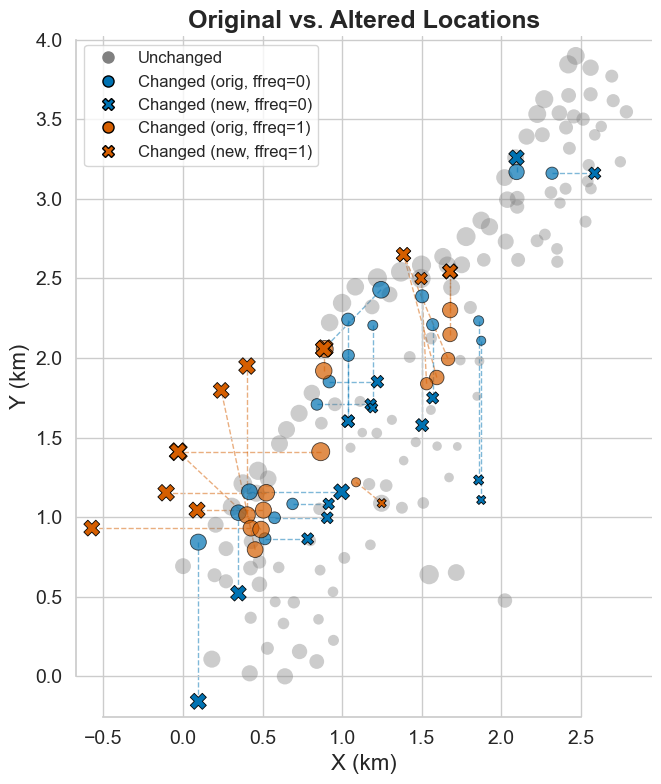

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Original vs. Altered Locations'}, xlabel='X (km)', ylabel='Y (km)'>)

In [31]:
new_sbs = optimized_data1["locations"]
new_dbs = optimized_data2["locations"]
orig_dbs = reference_data["locations"]
orig_sbs = reference_data["locations"]

# 2.1  gather global limits so every map has the *same* window
x_all = torch.cat([orig_sbs[:, 0], new_sbs[:, 0],
                   orig_dbs[:, 0], new_dbs[:, 0]])
y_all = torch.cat([orig_sbs[:, 1], new_sbs[:, 1],
                   orig_dbs[:, 1], new_dbs[:, 1]])
xlim = (x_all.min().item()-0.1, x_all.max().item()+0.1)
ylim = (y_all.min().item()-0.1, y_all.max().item()+0.1)

# 2.2  fixed canvas size for both plots
FIGSIZE = (10, 8)          # 6" wide, keeps PDF light & identical

# 2.3  produce and save the two figures
plot_location_changes_response(
    orig_sbs, new_sbs, reference_data["X"][:, 3].numpy(),
    reference_data["y"].numpy(),
    xlim=xlim, ylim=ylim, figsize=FIGSIZE,
    save_path=f"figures/location_changes_with_response_{ref1}.png",
)

plot_location_changes_response(
    orig_dbs, new_dbs, reference_data["X"][:, 3].numpy(),
    reference_data["y"].numpy(),
    xlim=xlim, ylim=ylim, figsize=FIGSIZE,
    save_path=f"figures/location_changes_with_response_{ref2}.png",
)

# ---------------------------------------------------------------
# 3.  LaTeX insertion (both will now have the same width/height)
# ---------------------------------------------------------------
# \includegraphics[width=\linewidth]{sbs_attack_map.pdf}
# \includegraphics[width=\linewidth]{dbs_attack_map.pdf}
